## Causal Inference Project: Economic Consequences of Immigration Policy and Enforcement

In [1]:
!pip install pyreadstat

In [157]:
import pyreadstat
import pandas as pd
import os
import math
from patsy import dmatrices

from sklearn.linear_model import LinearRegression
import statsmodels.api as smf
from statsmodels.iolib.summary2 import summary_col

In [158]:
os.chdir(r"C:\Users\andre\OneDrive\Desktop\Economic Data Science\Border Fencing, Migrant Flows, and Crossing Deaths")

In [159]:
dtafile1 = "AEAPP.dta"
df1, meta = pyreadstat.read_dta(dtafile1)

dtafile2 = "aggregate_apprehensions_death_by_year.dta"
df2, meta = pyreadstat.read_dta(dtafile2)

dtafile3 = "fencing_by_year.dta"
df3, meta = pyreadstat.read_dta(dtafile3)

In [160]:
sectors = [1,2,3,4,5,9]
fenced_list = []

for item, row in df1.iterrows():
    if row['sector_number'] in sectors:
        fenced_list.append(1)
    else:
        fenced_list.append(0)
        
df1['fenced'] = fenced_list

In [161]:
year_list = []

for item, row in df1.iterrows():
    if row['year'] >= 2006:
        year_list.append(1)
    else:
        year_list.append(0)
        
df1['sfa'] = year_list

In [162]:
list_interaction = []

for item, row in df1.iterrows():
    interaction = row['fenced']*row['sfa']
    list_interaction.append(interaction)
    
df1['fencedXsfa'] = list_interaction

In [163]:
lnapp_list = []

for item, row in df1.iterrows():
    try:
        lnapp_list.append(math.log(int(row['apprehensions'])))
    except:
        lnapp_list.append(None)
        
df1['lnapp'] = lnapp_list

In [164]:
deaths100k_list = []

for item, row in df1.iterrows():
    try:
        val = (row['deaths']/row['apprehensions'])*100000
        deaths100k_list.append(val)
    except:
        deaths100k.append(None)

df1['deathsper100k'] = deaths100k_list

In [194]:
df1['lagstaff'] = df1['staff'].shift(1)

In [166]:
df1.head()

,sector_number,year,sector_name,staff,apprehensions,deaths,months80,fenced,sfa,fencedXsfa,lnapp,deathsper100k,lagstaff
0,1,1992,San Diego,1009,565581,NaN,NaN,1,0,0,13.245609,NaN,NaN
1,1,1993,San Diego,992,531689,NaN,NaN,1,0,0,13.183814,NaN,1009
2,1,1994,San Diego,1290,450152,NaN,NaN,1,0,0,13.017341,NaN,992
3,1,1995,San Diego,1433,524231,NaN,NaN,1,0,0,13.169688,NaN,1290
4,1,1996,San Diego,1965,483815,NaN,NaN,1,0,0,13.089458,NaN,1433


In [202]:
df = df1.drop(columns = ['sector_number', 'sector_name', 'staff', 'apprehensions', 'deaths'])
df

,year,months80,fenced,sfa,fencedXsfa,lnapp,deathsper100k,lagstaff
0,1992,NaN,1,0,0,13.245609,NaN,NaN
1,1993,NaN,1,0,0,13.183814,NaN,1009
2,1994,NaN,1,0,0,13.017341,NaN,992
3,1995,NaN,1,0,0,13.169688,NaN,1290
4,1996,NaN,1,0,0,13.089458,NaN,1433
...,...,...,...,...,...,...,...,...
256,2016,5,1,1,1,12.137954,70.652465,3042
257,2017,5,1,1,1,11.831830,75.602274,3135
258,2018,5,1,1,1,11.996968,59.163575,3130
259,2019,5,1,1,1,12.734154,20.345880,3096


#### Dataset per regressioni

In [203]:
df_r1 = df[df.year > 1997]
df_r1 = df_r1[df_r1.year < 2018]
df_r1 = df_r1[df_r1.year != 2006]
df_r1 = df_r1[df_r1.year != 2007]
df_r1 = df_r1[df_r1.year != 2008]

In [209]:
months_list = []
lstaff_list = []
year_strs = []

for index, row in df_r1.iterrows():
    month = int(row['months80'])
    lstaff = float(row['lagstaff'])
    year_str = str(row['year'])
    
    months_list.append(month)
    lstaff_list.append(lstaff)
    year_strs.append(year_str)
    
    
df_r1['months80'] = months_list
df_r1['lagstaff'] = lstaff_list
df_r1['year'] = year_strs

In [210]:
df_r1 = df_r1.reset_index()
df_r1 = df_r1.drop(columns = ['index'])

In [211]:
df_r1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           153 non-null    object 
 1   months80       153 non-null    int64  
 2   fenced         153 non-null    int64  
 3   sfa            153 non-null    int64  
 4   fencedXsfa     153 non-null    int64  
 5   lnapp          153 non-null    float64
 6   deathsper100k  153 non-null    float64
 7   lagstaff       153 non-null    float64
dtypes: float64(3), int64(4), object(1)
memory usage: 9.7+ KB


#### regressione 1 - lnapp = c + m1*fenced + m2*sfa + m3*fenced x sfa + err

In questa prima parte ho eseguito la prima regressione come specificata nel titolo del paragrafo. Le librerie scelte mi permettono di fittare un Robust Linear Model.

In [139]:
y1, X1 = dmatrices('lnapp ~ fenced + sfa + fencedXsfa', data=df_r1, return_type='dataframe')

In [149]:
rlm_mod1= smf.RLM(y1, X1, M=smf.robust.norms.HuberT())
rlm_results1 = rlm_mod1.fit()
print(rlm_results1.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                  lnapp   No. Observations:                  153
Model:                            RLM   Df Residuals:                      149
Method:                          IRLS   Df Model:                            3
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Fri, 12 May 2023                                         
Time:                        18:28:13                                         
No. Iterations:                    17                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.7373      0.203     52.940      0.0

#### Regressione 2 - variabili di controllo per temperatura e pattuglie, controllo per esistenza di trend

In [216]:
y2, X2 = dmatrices('lnapp ~ fenced + sfa + fencedXsfa + months80 + lagstaff + year', data=df_r1, return_type='dataframe')

rlm_mod2= smf.RLM(y2, X2, M=smf.robust.norms.HuberT())
rlm_results2 = rlm_mod2.fit()

#### Regressione 3 - deathsper100k = c + m1*fenced + m2*sfa + m2*fenced X sfa + err

In [150]:
y3, X3 = dmatrices('deathsper100k ~ fenced + sfa + fencedXsfa', data=df_r1, return_type='dataframe')

rlm_mod3= smf.RLM(y3, X3, M=smf.robust.norms.HuberT())
rlm_results3 = rlm_mod3.fit()
print(rlm_results3.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:          deathsper100k   No. Observations:                  153
Model:                            RLM   Df Residuals:                      149
Method:                          IRLS   Df Model:                            3
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Fri, 12 May 2023                                         
Time:                        18:28:27                                         
No. Iterations:                    23                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     28.4435      6.556      4.339      0.0

#### Regressione 4 - variabili di controllo per temperatura e pattuglie, controllo per esistenza di trend

In [224]:
y4, X4 = dmatrices('deathsper100k ~ fenced + sfa + fencedXsfa + months80 + lagstaff + year', data=df_r1, return_type='dataframe')

rlm_mod4= smf.RLM(y4, X4, M=smf.robust.norms.HuberT())
rlm_results4 = rlm_mod4.fit()

#### TABELLA FINALE

In [225]:
dfoutput = summary_col([rlm_results1, rlm_results2,
                        rlm_results3, rlm_results4],stars=True)
print(dfoutput)


                lnapp I    lnapp II  deathsper100k I deathsper100k II
---------------------------------------------------------------------
Intercept      10.7373*** 10.1379*** 28.4435***      -12.2762        
               (0.2028)   (0.2731)   (6.5555)        (12.4680)       
fenced         1.1318***  0.6249***  -0.0748         -9.5836         
               (0.2484)   (0.1718)   (8.0289)        (7.8456)        
fencedXsfa     -0.4250    -0.7261*** -55.3604***     -57.5591***     
               (0.3414)   (0.2329)   (11.0346)       (10.6349)       
lagstaff                  0.0010***                  0.0237***       
                          (0.0001)                   (0.0037)        
months80                  0.1672***                  7.7609***       
                          (0.0314)                   (1.4360)        
sfa            -1.1088*** -2.0628*** 76.3014***      54.6719***      
               (0.2787)   (0.2622)   (9.0097)        (11.9698)       
year[T.1999.0]     

### Grafici

In [290]:
import matplotlib.pyplot as plt
import seaborn as sns

In [227]:
df3 = df3.rename({'total_p_vehicle': 'vehicle_barrier_Permanent',
                  'total_t_vehicle': 'vehicle_barrier_Temporary'}, axis=1)

In [232]:
lista1 = []

for item, row in df3.iterrows():
    elem1 = row['total_primary'] + row['total_secondary'] + row['total_tertiary']
    lista1.append(elem1)
    
df3['Pedestrian_Barrier'] = lista1

In [239]:
df3['Pedestrian_Barrier_M'] = df3.apply(lambda row: row.Pedestrian_Barrier/5280, axis=1)
df3['vehicle_barrier_Temporary_M'] = df3.apply(lambda row: row.vehicle_barrier_Temporary/5280, axis=1)
df3['vehicle_barrier_Permanent_M'] = df3.apply(lambda row: row.vehicle_barrier_Permanent/5280, axis=1)

In [241]:
df3.head()

,year,total_primary,total_secondary,total_tertiary,vehicle_barrier_Permanent,vehicle_barrier_Temporary,Pedestrian_Barrier,Pedestrian_Barrier_M,vehicle_barrier_Temporary_M,vehicle_barrier_Permanent_M
0,1992,65157.885265,0.0,0.0,872.65,0.0,65157.885265,12.340509,0.0,0.165275
1,1993,66259.726467,0.0,0.0,872.65,0.0,66259.726467,12.549191,0.0,0.165275
2,1994,96554.176723,0.0,0.0,872.65,0.0,96554.176723,18.286776,0.0,0.165275
3,1995,131820.148067,0.0,0.0,872.65,0.0,131820.148067,24.965937,0.0,0.165275
4,1996,131858.888245,0.0,0.0,872.65,0.0,131858.888245,24.973274,0.0,0.165275


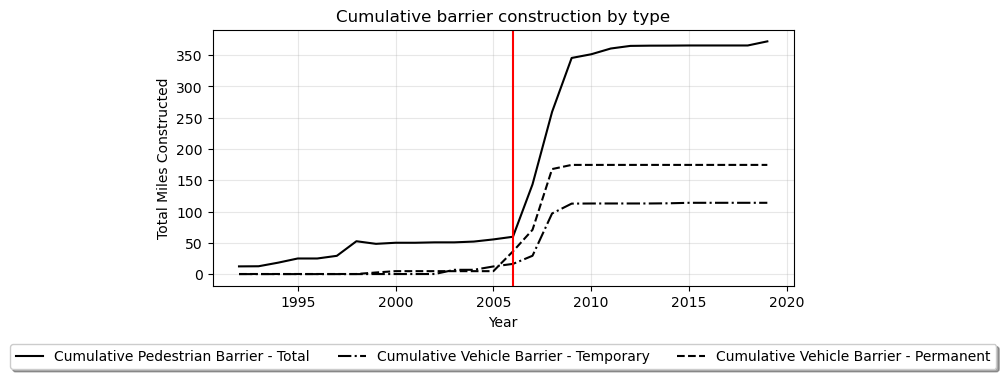

In [325]:
fig, ax = plt.subplots(figsize = (9,4))

plt.plot(df3.year, df3.Pedestrian_Barrier_M, color = 'black', label = 'Cumulative Pedestrian Barrier - Total')
plt.plot(df3.year, df3.vehicle_barrier_Temporary_M, linestyle = 'dashdot', color = 'black', label = 'Cumulative Vehicle Barrier - Temporary')
plt.plot(df3.year, df3.vehicle_barrier_Permanent_M, linestyle = 'dashed', color = 'black', label = 'Cumulative Vehicle Barrier - Permanent')

plt.axvline(x=2006, ymin=0, ymax=1, color = 'red')

plt.title('Cumulative barrier construction by type')
plt.xlabel('Year')
plt.ylabel('Total Miles Constructed')
plt.grid(alpha = 0.3)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=5)

plt.tight_layout()
plt.show()

In [276]:
df2.head()

,year,alldeath,allapprehensions
0,1998,263,1516680
1,1999,249,1537000
2,2000,380,1643679
3,2001,340,1235718
4,2002,320,929809


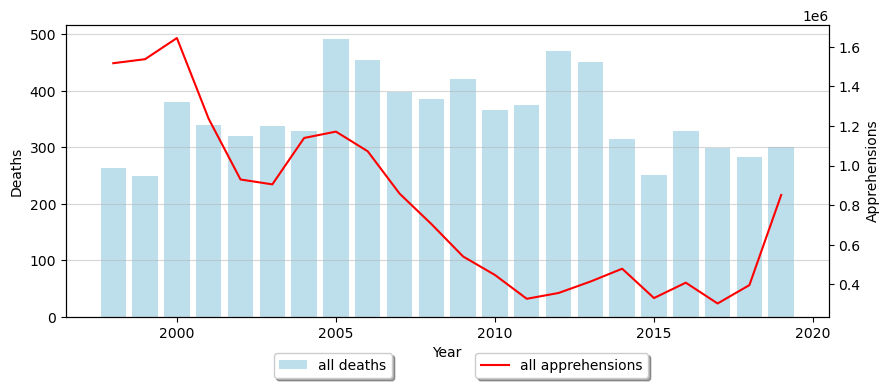

In [330]:
fig, ax = plt.subplots(figsize=(9,4))
ax2 = ax.twinx()

ax.bar(df2.year, df2.alldeath, label = 'all deaths', alpha = 0.8, color = 'lightblue')

ax2.plot(df2.year, df2.allapprehensions, label = 'all apprehensions', color = 'red')

# ax.legend(loc = 'upper left')
ax.legend(loc='upper center', bbox_to_anchor=(0.35, -0.1),
          fancybox=True, shadow=True, ncol=5)
ax2.legend(loc='upper center', bbox_to_anchor=(0.65, -0.1),
          fancybox=True, shadow=True, ncol=5)

ax.yaxis.grid(alpha = 0.5)

ax.set_xlabel('Year')
ax.set_ylabel("Deaths")
ax2.set_ylabel("Apprehensions")
plt.tight_layout()

plt.show()